# Original work presented in this notebook


1. When holding the training split constant at 1,152 training samples, we will now introduce a training/testing mismatch of data. We accomplish this by _only_ training on the data corresponding to 1 hour of irradiation and testing on the data which includes multiple distinct irradiation times.
2. There now exists a separate notebook that focuses on the fixed irradiation time experiments. This is important because that is the scenario in which we focus on evaluating the feature importances and learning curves of each individual algorithm. Now, in this notebook, we are focused on broad strokes trends in model performance as the: training split, number of irradiation times, and models are varied. 
3. The nesting of variations is now:
        a. Training split (distributed across full dataset versus held constant at 1,152 T_{irr}=1 samples)
        b. Model (3 regularized linear, 3 decision tree based)
        c. Number of irradiation times (1, 2, 3, 4, 5).
4. All models, results, etc. will now be given uniquely identifying names so that they can be accessed later when generating comparison figures.

# Setting up the notebook

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scikitplot as skplt
import time
warnings.simplefilter(action='ignore')  
sns.set_context("talk")
sns.set_style("dark")
pd.set_option('display.max_columns', 100)
# Models I will use
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA

# Various other tools in sklearn I will use
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Importing prebuilt functions

In [3]:
def full_pipeline(w, test_size, sigma, mu, n, seed):
    
    u235, u238, u234, u236 = pd.read_csv(
        'SCALE/multi_irrad_times/u235_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_1hr.csv', skipinitialspace=True).T
    
    u235.columns, u238.columns, u234.columns, u236.columns = u235.iloc[0], u238.iloc[0], u234.iloc[0], u236.iloc[0]
    
    columns = u235.columns
    
    u235 = u235.drop(index=['boundaries'])
    u238 = u238.drop(index=['boundaries'])
    u234 = u234.drop(index=['boundaries'])
    u236 = u236.drop(index=['boundaries'])
    
    imputer = SimpleImputer(fill_value=0, strategy="constant")    
    u235_values = imputer.fit_transform(u235.values)
    u238_values = imputer.fit_transform(u238.values)
    u234_values = imputer.fit_transform(u234.values)
    u236_values = imputer.fit_transform(u236.values)

    X, y = centrifuge(w=w, iso1 = u238_values, iso2 = u235_values, iso3 = u234_values, iso4 = u236_values)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    X_train, y_train = replicate_gauss_noise(
        X_train, y_train, sigma, mu, n)
    X_test, y_test = replicate_gauss_noise(
        X_test, y_test, sigma, mu, n)
    
    return X_train, X_test, y_train, y_test, columns

In [4]:
def two_irrad_full_pipeline(w, test_size, sigma, mu, n, seed):
    
    u235_1h, u238_1h, u234_1h, u236_1h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_1hr.csv', skipinitialspace=True).T
    
    u235_2h, u238_2h, u234_2h, u236_2h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_2hr.csv', skipinitialspace=True).T
    
    u235 = pd.concat([u235_1h, u235_2h])
    u238 = pd.concat([u238_1h, u238_2h])
    u234 = pd.concat([u234_1h, u234_2h])
    u236 = pd.concat([u236_1h, u236_2h])
    
    u235.columns, u238.columns, u234.columns, u236.columns = u235.iloc[0], u238.iloc[0], u234.iloc[0], u236.iloc[0]
    
    columns = u235.columns
    
    u235 = u235.drop(index=['boundaries'])
    u238 = u238.drop(index=['boundaries'])
    u234 = u234.drop(index=['boundaries'])
    u236 = u236.drop(index=['boundaries'])
    
    imputer = SimpleImputer(fill_value=0, strategy="constant")    
    u235_values = imputer.fit_transform(u235.values)
    u238_values = imputer.fit_transform(u238.values)
    u234_values = imputer.fit_transform(u234.values)
    u236_values = imputer.fit_transform(u236.values)

    X, y = centrifuge(w=w, iso1 = u238_values, iso2 = u235_values, iso3 = u234_values, iso4 = u236_values)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    X_train, y_train = replicate_gauss_noise(
        X_train, y_train, sigma, mu, n)
    X_test, y_test = replicate_gauss_noise(
        X_test, y_test, sigma, mu, n)
    
    return X_train, X_test, y_train, y_test, columns

In [5]:
def three_irrad_full_pipeline(w, test_size, sigma, mu, n, seed):
    
    u235_0h, u238_0h, u234_0h, u236_0h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_0hr.csv', skipinitialspace=True).T    
    
    u235_1h, u238_1h, u234_1h, u236_1h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_1hr.csv', skipinitialspace=True).T
    
    u235_2h, u238_2h, u234_2h, u236_2h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_2hr.csv', skipinitialspace=True).T
    
    u235 = pd.concat([u235_0h, u235_1h, u235_2h])
    u238 = pd.concat([u238_0h, u238_1h, u238_2h])
    u234 = pd.concat([u234_0h, u234_1h, u234_2h])
    u236 = pd.concat([u236_0h, u236_1h, u236_2h])
    
    u235.columns, u238.columns, u234.columns, u236.columns = u235.iloc[0], u238.iloc[0], u234.iloc[0], u236.iloc[0]
    
    columns = u235.columns
    
    u235 = u235.drop(index=['boundaries'])
    u238 = u238.drop(index=['boundaries'])
    u234 = u234.drop(index=['boundaries'])
    u236 = u236.drop(index=['boundaries'])
    
    imputer = SimpleImputer(fill_value=0, strategy="constant")    
    u235_values = imputer.fit_transform(u235.values)
    u238_values = imputer.fit_transform(u238.values)
    u234_values = imputer.fit_transform(u234.values)
    u236_values = imputer.fit_transform(u236.values)

    X, y = centrifuge(w=w, iso1 = u238_values, iso2 = u235_values, iso3 = u234_values, iso4 = u236_values)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    X_train, y_train = replicate_gauss_noise(
        X_train, y_train, sigma, mu, n)
    X_test, y_test = replicate_gauss_noise(
        X_test, y_test, sigma, mu, n)
    
    return X_train, X_test, y_train, y_test, columns

In [6]:
def four_irrad_full_pipeline(w, test_size, sigma, mu, n, seed):
    
    u235_0h, u238_0h, u234_0h, u236_0h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_0hr.csv', skipinitialspace=True).T    
    
    u235_1h, u238_1h, u234_1h, u236_1h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_1hr.csv', skipinitialspace=True).T
    
    u235_2h, u238_2h, u234_2h, u236_2h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_2hr.csv', skipinitialspace=True).T

    u235_3h, u238_3h, u234_3h, u236_3h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_3hr.csv', skipinitialspace=True).T
    
    
    u235 = pd.concat([u235_0h, u235_1h, u235_2h, u235_3h])
    u238 = pd.concat([u238_0h, u238_1h, u238_2h, u238_3h])
    u234 = pd.concat([u234_0h, u234_1h, u234_2h, u234_3h])
    u236 = pd.concat([u236_0h, u236_1h, u236_2h, u236_3h])
    
    u235.columns, u238.columns, u234.columns, u236.columns = u235.iloc[0], u238.iloc[0], u234.iloc[0], u236.iloc[0]
    
    columns = u235.columns
    
    u235 = u235.drop(index=['boundaries'])
    u238 = u238.drop(index=['boundaries'])
    u234 = u234.drop(index=['boundaries'])
    u236 = u236.drop(index=['boundaries'])
    
    imputer = SimpleImputer(fill_value=0, strategy="constant")    
    u235_values = imputer.fit_transform(u235.values)
    u238_values = imputer.fit_transform(u238.values)
    u234_values = imputer.fit_transform(u234.values)
    u236_values = imputer.fit_transform(u236.values)

    X, y = centrifuge(w=w, iso1 = u238_values, iso2 = u235_values, iso3 = u234_values, iso4 = u236_values)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    X_train, y_train = replicate_gauss_noise(
        X_train, y_train, sigma, mu, n)
    X_test, y_test = replicate_gauss_noise(
        X_test, y_test, sigma, mu, n)
    
    return X_train, X_test, y_train, y_test, columns

In [7]:
def five_irrad_full_pipeline(w, test_size, sigma, mu, n, seed):
    
    u235_0h, u238_0h, u234_0h, u236_0h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_0hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_0hr.csv', skipinitialspace=True).T    
    
    u235_1h, u238_1h, u234_1h, u236_1h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_1hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_1hr.csv', skipinitialspace=True).T
    
    u235_2h, u238_2h, u234_2h, u236_2h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_2hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_2hr.csv', skipinitialspace=True).T

    u235_3h, u238_3h, u234_3h, u236_3h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_3hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_3hr.csv', skipinitialspace=True).T
    
    u235_4h, u238_4h, u234_4h, u236_4h = pd.read_csv(
        'SCALE/multi_irrad_times/u235_4hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u238_4hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u234_4hr.csv', skipinitialspace=True).T, pd.read_csv(
        'SCALE/multi_irrad_times/u236_4hr.csv', skipinitialspace=True).T
    
    
    u235 = pd.concat([u235_0h, u235_1h, u235_2h, u235_3h, u235_4h])
    u238 = pd.concat([u238_0h, u238_1h, u238_2h, u238_3h, u238_4h])
    u234 = pd.concat([u234_0h, u234_1h, u234_2h, u234_3h, u234_4h])
    u236 = pd.concat([u236_0h, u236_1h, u236_2h, u236_3h, u236_4h])
    
    u235.columns, u238.columns, u234.columns, u236.columns = u235.iloc[0], u238.iloc[0], u234.iloc[0], u236.iloc[0]
    
    columns = u235.columns
    
    u235 = u235.drop(index=['boundaries'])
    u238 = u238.drop(index=['boundaries'])
    u234 = u234.drop(index=['boundaries'])
    u236 = u236.drop(index=['boundaries'])
    
    imputer = SimpleImputer(fill_value=0, strategy="constant")    
    u235_values = imputer.fit_transform(u235.values)
    u238_values = imputer.fit_transform(u238.values)
    u234_values = imputer.fit_transform(u234.values)
    u236_values = imputer.fit_transform(u236.values)

    X, y = centrifuge(w=w, iso1 = u238_values, iso2 = u235_values, iso3 = u234_values, iso4 = u236_values)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)
    
    X_train, X_test = one_d_scaler(X_train, X_test)
    
    X_train, y_train = replicate_gauss_noise(
        X_train, y_train, sigma, mu, n)
    X_test, y_test = replicate_gauss_noise(
        X_test, y_test, sigma, mu, n)
    
    return X_train, X_test, y_train, y_test, columns

In [8]:
def centrifuge(w, iso1, iso2, iso3, iso4):
    """`w` is an array of all enrichment levels that you want to generate.
    Enrichment refers to the atom percent of iso2
    iso1, iso2, iso3, iso4 = U238, U235, U234, U236"""
    
    X = iso1
    y = np.zeros(iso1.shape[0])
    for enrichment in w:
        
        abundance4 = u4(enrichment)
        abundance6 = u6(enrichment)
        
        enriched = (enrichment * iso2) + (abundance4 * iso3) + (abundance6 * iso4) + ((1 - enrichment - abundance4 - abundance6) * iso1)
        
        X = np.append(X, enriched, axis=0)
        for j in range(0, iso1.shape[0]):
            y = np.append(y, enrichment)
    return X, y
        

In [9]:
def u6(enrichment):
    abundance6 = 0.0004 * enrichment ** 2 + 0.0045 * enrichment - 2e-5
    return abundance6

def u4(enrichment):
    abundance4 = 0.0053 * enrichment ** 2 + 0.0058 * enrichment + 4e-5
    return abundance4

In [10]:
def one_d_scaler(X_train, X_test):
    """This function performs normalization across features per instance."""
    for x in [X_train, X_test]: # Normalization
        total = np.sum(x, axis=1)
        for i in range(0,len(x[:,0])):
            x[i] = x[i] / total[i]
    return X_train, X_test

In [11]:
def reg_comp(seed, X_train, y_train, X_test, y_test, ridge, 
             decision_tree, lasso, elastic_net, random_forest,
            adaboost_reg):
    """This is the help documentation for regression comparison"""
    seed = seed

    models = []
    models.append(('Ridge', ridge))    
    models.append(('Lasso', lasso))
    models.append(('Elastic Net', elastic_net))
    models.append(('Decision Tree', decision_tree))
    models.append(('Random Forest', random_forest))
    models.append(('AdaBoost Forest', adaboost_reg))

    results = []
    names = []
    scoring = 'neg_mean_absolute_error'
    
    print("Model: Mean (Standard Deviation)")

    for name, model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        result = abs(pred - y_test)
        results.append(result)
        names.append(name)
        msg = "%s: %f (%f)" % (name, result.mean(), result.std())
        print(msg)
    
    fig = plt.figure(figsize=(6, 6), dpi=1200)
    fig.suptitle("Regression Algorithm Performance Comparison")
    ax = fig.add_subplot(111)
    # sns.boxplot(data=results_cc_reg, linewidth=1, color='orange')
    sns.violinplot(data=results, cut=0, width=1, linewidth=.8,
                   inner='point', orient='h', scale='area')
    ax.set_yticklabels(names)
    plt.xscale('linear')
    plt.xlabel("MAE")
    plt.xlabel("Mean Absolute Error")
    plt.xticks(rotation=30)
    plt.yticks(rotation=0)
    plt.savefig('ORNL_figures/regression_comparison.png')
    plt.show()

    return results, names

In [12]:
def model_gsearch_cval(model, X_train, y_train, param_grid, cv, scorer):
    grid_search = GridSearchCV(model, param_grid, cv=cv,
                               scoring=scorer)
    grid_search.fit(X_train, y_train)
    gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(
        by=['rank_test_score'])
    grid_search.best_estimator_
    scores = cross_val_score(
                grid_search.best_estimator_, X_train, y_train, cv=cv,
                scoring=scorer)
    # rmse_scores = np.sqrt(-scores)
    Message = print("Cross-validation statistics for best model:",
                    'Scores:', scores, 'Mean:', scores.mean(), 
                    'Standard Deviation:', scores.std())
    return gs_results, grid_search.best_estimator_, grid_search, Message

In [13]:
def gauss_noise(X, sigma, mu):
    noise = sigma * np.random.randn(X.shape[0], X.shape[1]) + mu
    X_noise = X * ( 1 + noise)
    return X_noise

In [14]:
def replicate_gauss_noise(X, y, sigma, mu, n):
    X_rep = X
    y_rep = y
    for i in range(n):
        X_n = gauss_noise(X, sigma, mu)
        X_rep = np.append(X_rep, X_n, axis=0)
        y_rep = np.append(y_rep, y, axis=0)
    return X_rep, y_rep

# Setting up all of the data for this notebook

In [15]:
w = np.array([0.0002, 0.0071, 0.03, 0.20, 0.50, 0.63, 0.97])

X_train_1irr, X_test_1irr, y_train_1irr, y_test_1irr, columns = full_pipeline(
    w=w, test_size=0.2, sigma=0.05, mu=0, n=0, seed=42)

X_train_2irr, X_test_2irr, y_train_2irr, y_test_2irr, columns = two_irrad_full_pipeline(
    w=w, test_size=0.2, sigma=0.05, mu=0, n=0, seed=42)

X_train_3irr, X_test_3irr, y_train_3irr, y_test_3irr, columns = three_irrad_full_pipeline(
    w=w, test_size=0.2, sigma=0.05, mu=0, n=0, seed=42)

X_train_4irr, X_test_4irr, y_train_4irr, y_test_4irr, columns = four_irrad_full_pipeline(
    w=w, test_size=0.2, sigma=0.05, mu=0, n=0, seed=42)

X_train_5irr, X_test_5irr, y_train_5irr, y_test_5irr, columns = five_irrad_full_pipeline(
    w=w, test_size=0.2, sigma=0.05, mu=0, n=0, seed=42)

# Tuning the 5 models per algorithm

# Ridge Regression

In [16]:
param_grid=[{
    'alpha': [1e-3, 1e-2, 1e-1,
              1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
              1e2, 2,
              1e3, 1.1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge_1irr, best_ridge_1irr, ridge_search_1irr, Message_1irr= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train_1irr, y_train=y_train_1irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.20885933 -0.18146698 -0.22259362 -0.21559404 -0.22375483] Mean: -0.21045376261949653 Standard Deviation: 0.01544987251459447


In [17]:
best_ridge_1irr

Ridge(alpha=15, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='svd', tol=0.001)

In [18]:
param_grid=[{
    'alpha': [1e-3, 1e-2, 1e-1,
              1, 5, 6, 7, 8, 9, 10, 20, 30, 31, 40, 50, 60, 70, 80, 90,
              1e2, 1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge_2irr, best_ridge_2irr, ridge_search_2irr, Message_2irr= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train_2irr, y_train=y_train_2irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.20155509 -0.22138866 -0.21566215 -0.18911908 -0.23023398] Mean: -0.21159179066684866 Standard Deviation: 0.0146002452836376


In [19]:
best_ridge_2irr

Ridge(alpha=31, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='auto', tol=0.001)

In [20]:
param_grid=[{
    'alpha': [1e-3, 1e-2, 1e-1,
              1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 45, 50, 60, 70, 80, 90,
              1e2, 1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge_3irr, best_ridge_3irr, ridge_search_3irr, Message_3irr= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train_3irr, y_train=y_train_3irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.21471623 -0.22160297 -0.21186498 -0.20803389 -0.20717226] Mean: -0.2126780652129173 Standard Deviation: 0.005222094462753062


In [21]:
best_ridge_3irr

Ridge(alpha=45, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='auto', tol=0.001)

In [22]:
param_grid=[{
    'alpha': [1e-3, 1e-2, 1e-1,
              1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 45, 50,
              60, 61, 70, 80, 90,
              1e2, 1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge_4irr, best_ridge_4irr, ridge_search_4irr, Message_4irr= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train_4irr, y_train=y_train_4irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.20904834 -0.20875345 -0.21405911 -0.20100943 -0.21947741] Mean: -0.2104695473924294 Standard Deviation: 0.006139793932818645


In [23]:
best_ridge_4irr

Ridge(alpha=61, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='auto', tol=0.001)

In [24]:
param_grid=[{
    'alpha': [1e-3, 1e-2, 1e-1,
              1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 45, 50,
              60, 61, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
              1e2, 1e3, 1e4, 1e5,], 
    'solver': ['auto', 'svd', 'cholesky']
}]

results_ridge_5irr, best_ridge_5irr, ridge_search_5irr, Message_5irr= model_gsearch_cval(
    model=Ridge(random_state=42), X_train=X_train_5irr, y_train=y_train_5irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")

Cross-validation statistics for best model: Scores: [-0.21672409 -0.20717642 -0.21770876 -0.21239782 -0.21500722] Mean: -0.21380286136462315 Standard Deviation: 0.003771579005792833


In [25]:
best_ridge_5irr

Ridge(alpha=78, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='auto', tol=0.001)

# Evaluating the five tuned models with different combinations of training and testing datasets

In [142]:
ridges_Xys = [(best_ridge_1irr, X_train_1irr, y_train_1irr, X_test_1irr, y_test_1irr),
              (best_ridge_1irr, X_train_1irr, y_train_1irr, X_test_2irr, y_test_2irr),
              (best_ridge_1irr, X_train_1irr, y_train_1irr, X_test_3irr, y_test_3irr),
              (best_ridge_1irr, X_train_1irr, y_train_1irr, X_test_4irr, y_test_4irr),
              (best_ridge_1irr, X_train_1irr, y_train_1irr, X_test_5irr, y_test_5irr),
              (best_ridge_2irr, X_train_2irr, y_train_2irr, X_test_2irr, y_test_2irr),
              (best_ridge_3irr, X_train_3irr, y_train_3irr, X_test_3irr, y_test_3irr), 
              (best_ridge_4irr, X_train_4irr, y_train_4irr, X_test_4irr, y_test_4irr), 
              (best_ridge_5irr, X_train_5irr, y_train_5irr, X_test_5irr, y_test_5irr)]

In [143]:
results = []
for ridge, X_train, y_train, X_test, y_test in ridges_Xys:
        ridge.fit(X_train, y_train)
        pred = ridge.predict(X_test)
        result = abs(pred - y_test)
        results.append(result)

In [144]:
for i in results:
    print(np.mean(i))

0.2158009085182561
0.21087186061363758
0.20639246601693576
0.21604404597002225
0.20188803676826417
0.21096707674128964
0.2064597569636174
0.21634451971773203
0.20199082180754035


In [145]:
names = ["1/1", "1/2", "1/3", "1/4", "1/5", "2/2", "3/3", "4/4", "5/5" ]

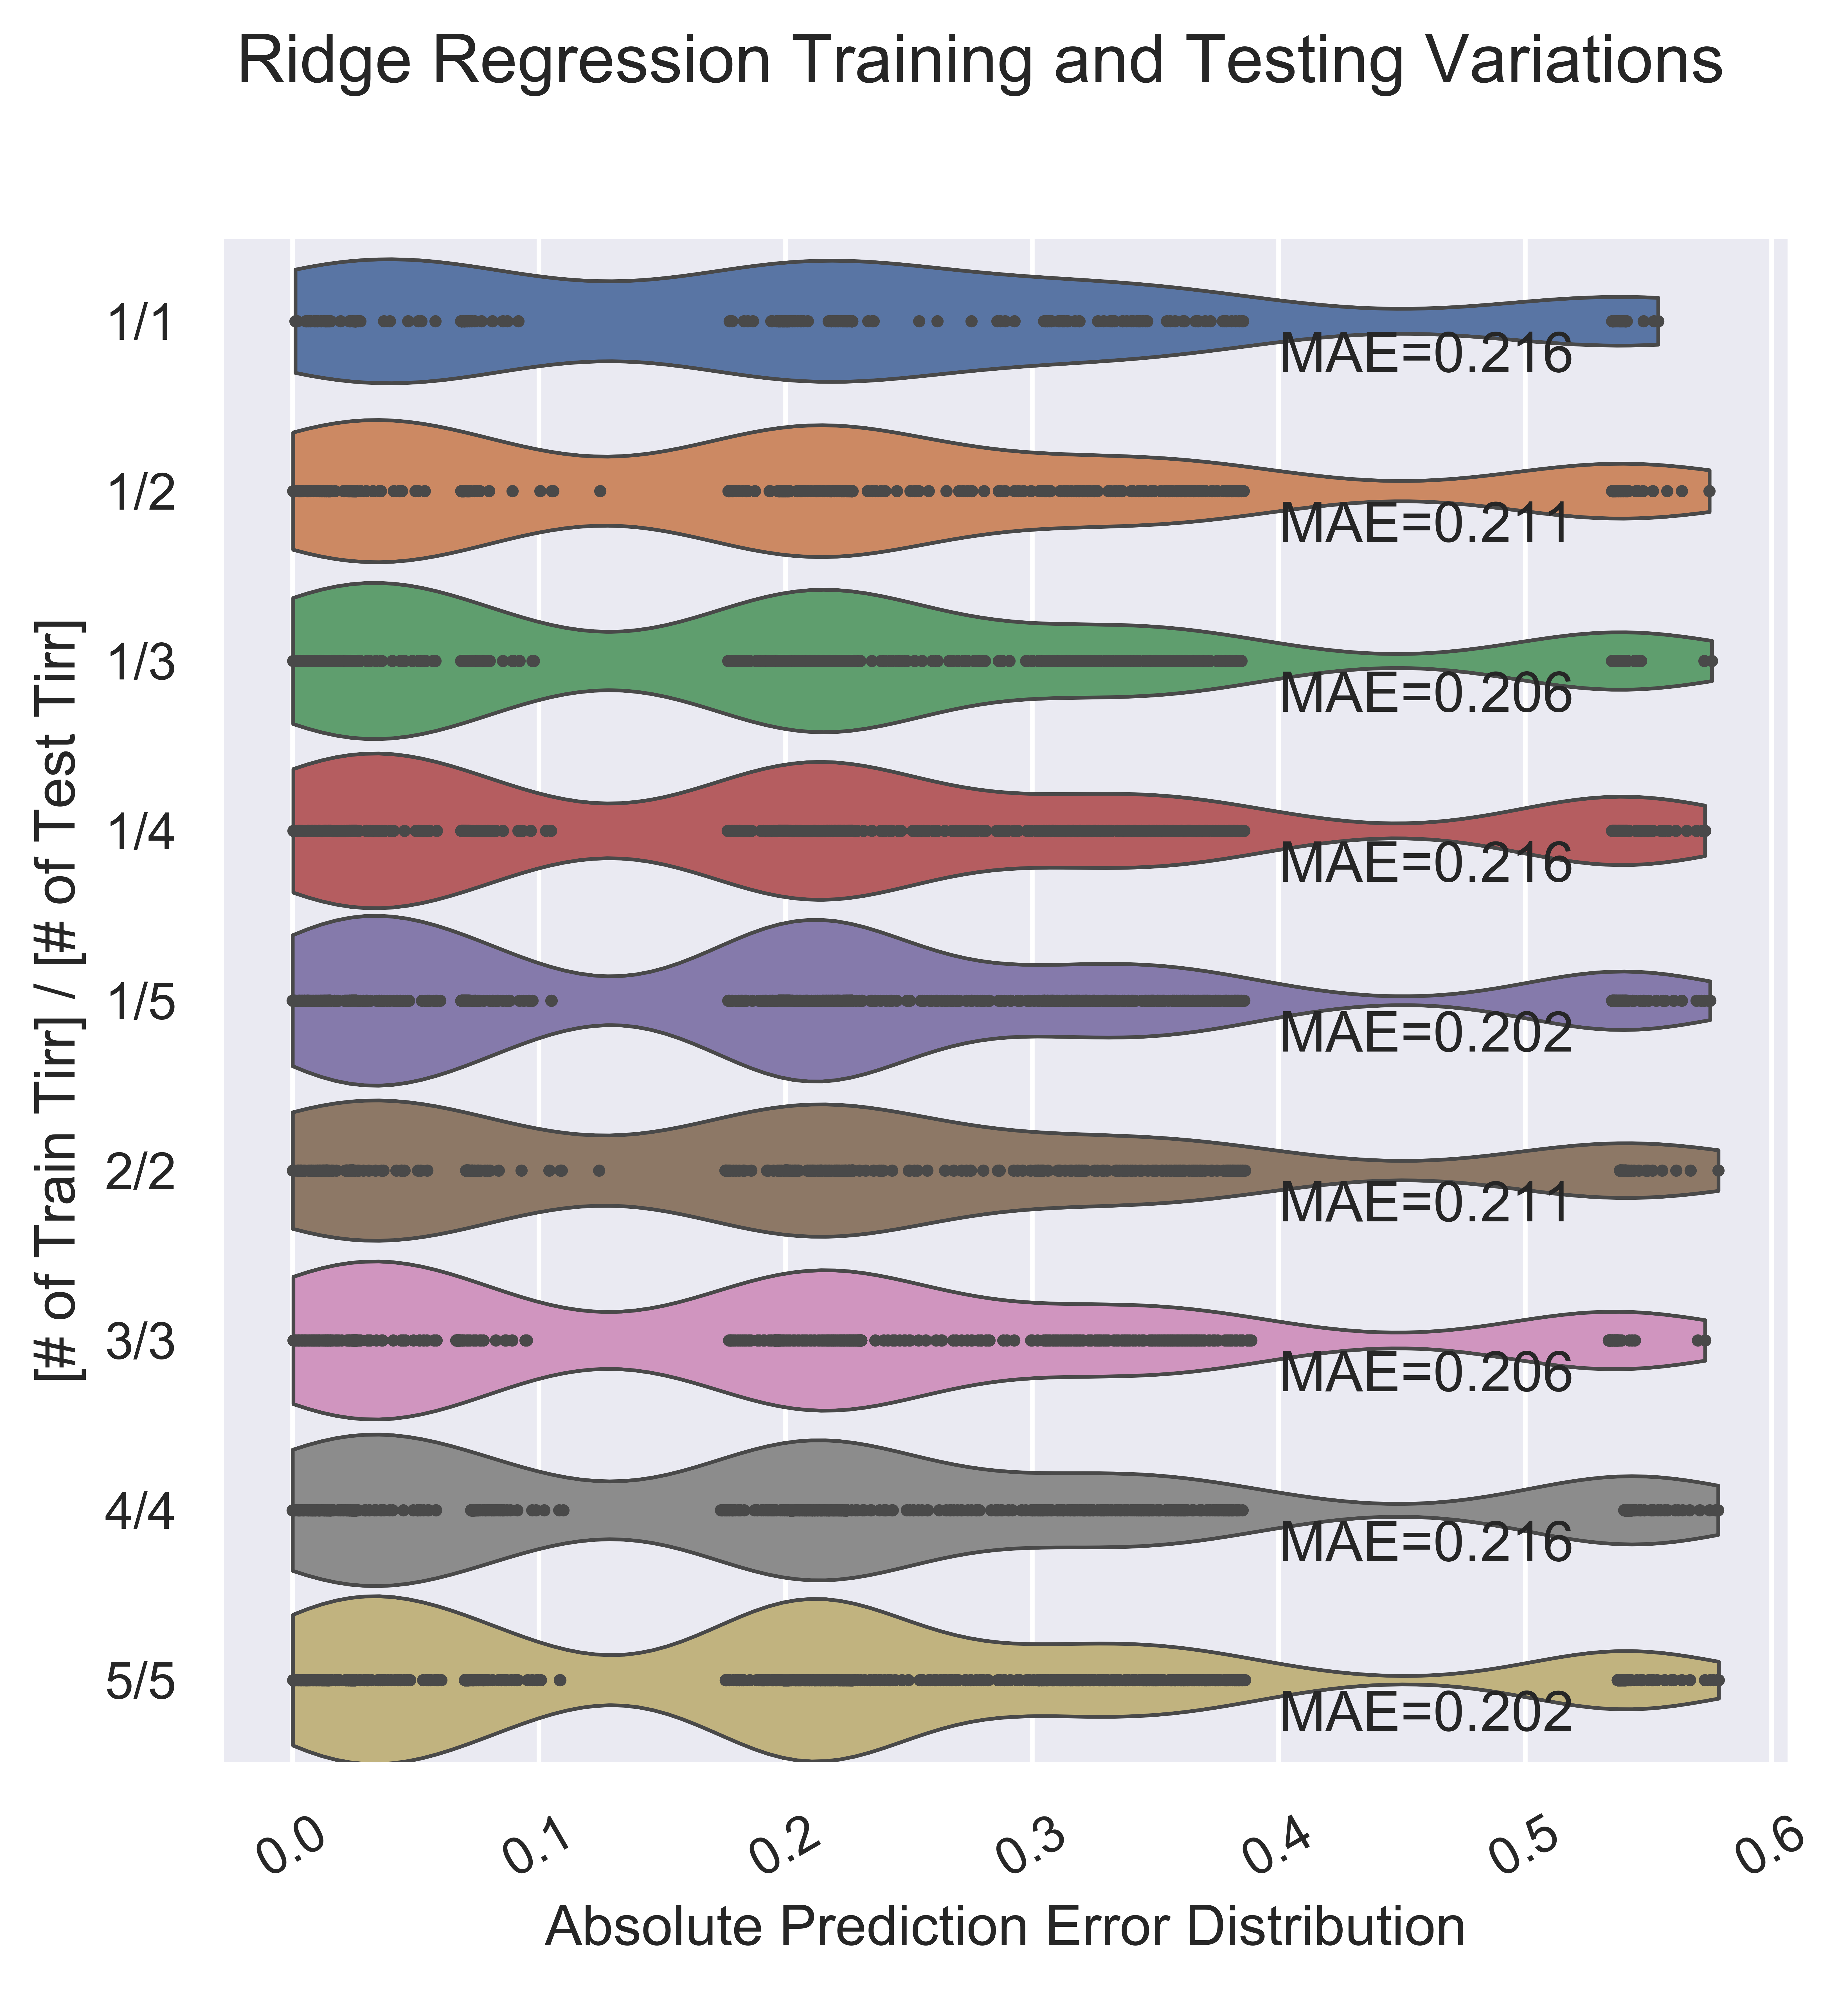

In [148]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(6, 6), dpi=1200)
fig.suptitle("Ridge Regression Training and Testing Variations")
ax = fig.add_subplot(111)
# sns.boxplot(data=results, linewidth=1, color='orange', orient='h')
sns.violinplot(data=results, cut=0, width=1, linewidth=.8,
             inner='point', orient='h', scale='area')
ax.set_yticklabels(names)
ax.set_ylabel("[# of Train Tirr] / [# of Test Tirr]")
plt.xscale('linear')
plt.xlabel("MAE")
plt.xlabel("Absolute Prediction Error Distribution")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.text(0.4, 0.3, "MAE=0.216")
plt.text(0.4, 1.3, "MAE=0.211")
plt.text(0.4, 2.3, "MAE=0.206")
plt.text(0.4, 3.3, "MAE=0.216")
plt.text(0.4, 4.3, "MAE=0.202")
plt.text(0.4, 5.3, "MAE=0.211")
plt.text(0.4, 6.3, "MAE=0.206")
plt.text(0.4, 7.3, "MAE=0.216")
plt.text(0.4, 8.3, "MAE=0.202")
plt.show()



# Decision Trees

In [31]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [10, 11, 12, 13, 14, 15, 16, None],  
    'min_samples_split': [2], 'min_samples_leaf': [5, 10], 
    'max_features': [None], 'max_leaf_nodes': [25, 50], 
    'random_state': [42]
}]

results_tree_reg_1irr, best_tree_reg_1irr, tree_search_1irr, Message_1irr = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train_1irr, y_train=y_train_1irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.01659264 -0.01748918 -0.02578957 -0.01628261 -0.02373913] Mean: -0.01997862450592885 Standard Deviation: 0.003980733663433233
This grid-search took: 163.00369262695312 seconds.


In [32]:
best_tree_reg_1irr

DecisionTreeRegressor(criterion='mae', max_depth=13, max_features=None,
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [33]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [10, 12, 14, 16, 18, 20, None],  
    'min_samples_split': [2], 'min_samples_leaf': [5, 10], 
    'max_features': [None], 'max_leaf_nodes': [25, 50], 
    'random_state': [42]
}]

results_tree_reg_2irr, best_tree_reg_2irr, tree_search_2irr, Message_2irr = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train_2irr, y_train=y_train_2irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.01841367 -0.01933471 -0.01128612 -0.01583232 -0.01198457] Mean: -0.015370275299443553 Standard Deviation: 0.003266062262195965
This grid-search took: 337.19059658050537 seconds.


In [34]:
best_tree_reg_2irr

DecisionTreeRegressor(criterion='mae', max_depth=16, max_features=None,
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [35]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [10, 12, 14, 16, 18, 20, None],  
    'min_samples_split': [2], 'min_samples_leaf': [5, 10], 
    'max_features': [None], 'max_leaf_nodes': [25, 50], 
    'random_state': [42]
}]

results_tree_reg_3irr, best_tree_reg_3irr, tree_search_3irr, Message_3irr = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train_3irr, y_train=y_train_3irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.0117341  -0.00637178 -0.00972084 -0.01568517 -0.01143054] Mean: -0.010988485063951883 Standard Deviation: 0.003024270590743316
This grid-search took: 240.4940106868744 seconds.


In [36]:
best_tree_reg_3irr

DecisionTreeRegressor(criterion='mae', max_depth=14, max_features=None,
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [37]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [10, 12, 14, 16, 18, 20, None],  
    'min_samples_split': [2], 'min_samples_leaf': [5, 10], 
    'max_features': [None], 'max_leaf_nodes': [25, 50], 
    'random_state': [42]
}]

results_tree_reg_4irr, best_tree_reg_4irr, tree_search_4irr, Message_4irr = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train_4irr, y_train=y_train_4irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.01145629 -0.01091106 -0.00785423 -0.01381737 -0.01221042] Mean: -0.011249875877629946 Standard Deviation: 0.0019597195110911104
This grid-search took: 407.06645226478577 seconds.


In [38]:
best_tree_reg_4irr

DecisionTreeRegressor(criterion='mae', max_depth=12, max_features=None,
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [39]:
tick = time.time()
param_grid= [{
    'criterion': ['mae'], 'splitter': ['best'], 
    'max_depth': [10, 12, 14, 16, 18, 20, None],  
    'min_samples_split': [2], 'min_samples_leaf': [5, 10], 
    'max_features': [None], 'max_leaf_nodes': [25, 50], 
    'random_state': [42]
}]

results_tree_reg_5irr, best_tree_reg_5irr, tree_search_5irr, Message_5irr = model_gsearch_cval(
    model=DecisionTreeRegressor(), X_train=X_train_5irr, y_train=y_train_5irr,
    param_grid=param_grid, cv=5, scorer="neg_mean_absolute_error")
tock = time.time()
print("This grid-search took:", tock-tick, "seconds.")

Cross-validation statistics for best model: Scores: [-0.01115069 -0.01119792 -0.01184878 -0.00776675 -0.01421606] Mean: -0.011236041666666665 Standard Deviation: 0.0020640085157156126
This grid-search took: 603.3192362785339 seconds.


In [40]:
best_tree_reg_5irr

DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
                      max_leaf_nodes=50, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

# Evaluating the decision tree models

In [117]:
ridges_Xys = [(best_tree_reg_1irr, X_train_1irr, y_train_1irr, X_test_1irr, y_test_1irr),
              (best_tree_reg_1irr, X_train_1irr, y_train_1irr, X_test_2irr, y_test_2irr),
              (best_tree_reg_1irr, X_train_1irr, y_train_1irr, X_test_3irr, y_test_3irr),
              (best_tree_reg_1irr, X_train_1irr, y_train_1irr, X_test_4irr, y_test_4irr),
              (best_tree_reg_1irr, X_train_1irr, y_train_1irr, X_test_5irr, y_test_5irr),
              (best_tree_reg_2irr, X_train_2irr, y_train_2irr, X_test_2irr, y_test_2irr),
              (best_tree_reg_3irr, X_train_3irr, y_train_3irr, X_test_3irr, y_test_3irr), 
              (best_tree_reg_4irr, X_train_4irr, y_train_4irr, X_test_4irr, y_test_4irr), 
              (best_tree_reg_5irr, X_train_5irr, y_train_5irr, X_test_5irr, y_test_5irr)]

In [136]:
results = []
abs_results = []
for ridge, X_train, y_train, X_test, y_test in ridges_Xys:
        ridge.fit(X_train, y_train)
        pred = ridge.predict(X_test)
        result = (pred - y_test)
        abs_result = abs(pred - y_test)
        results.append(result)
        abs_results.append(abs_result)
for i in abs_results:
    print(np.mean(i))

0.017614236111111112
0.0113765625
0.010924421296296297
0.014249652777777776
0.015670694444444445
0.019107291666666668
0.006618634259259259
0.009717621527777777
0.010231180555555554


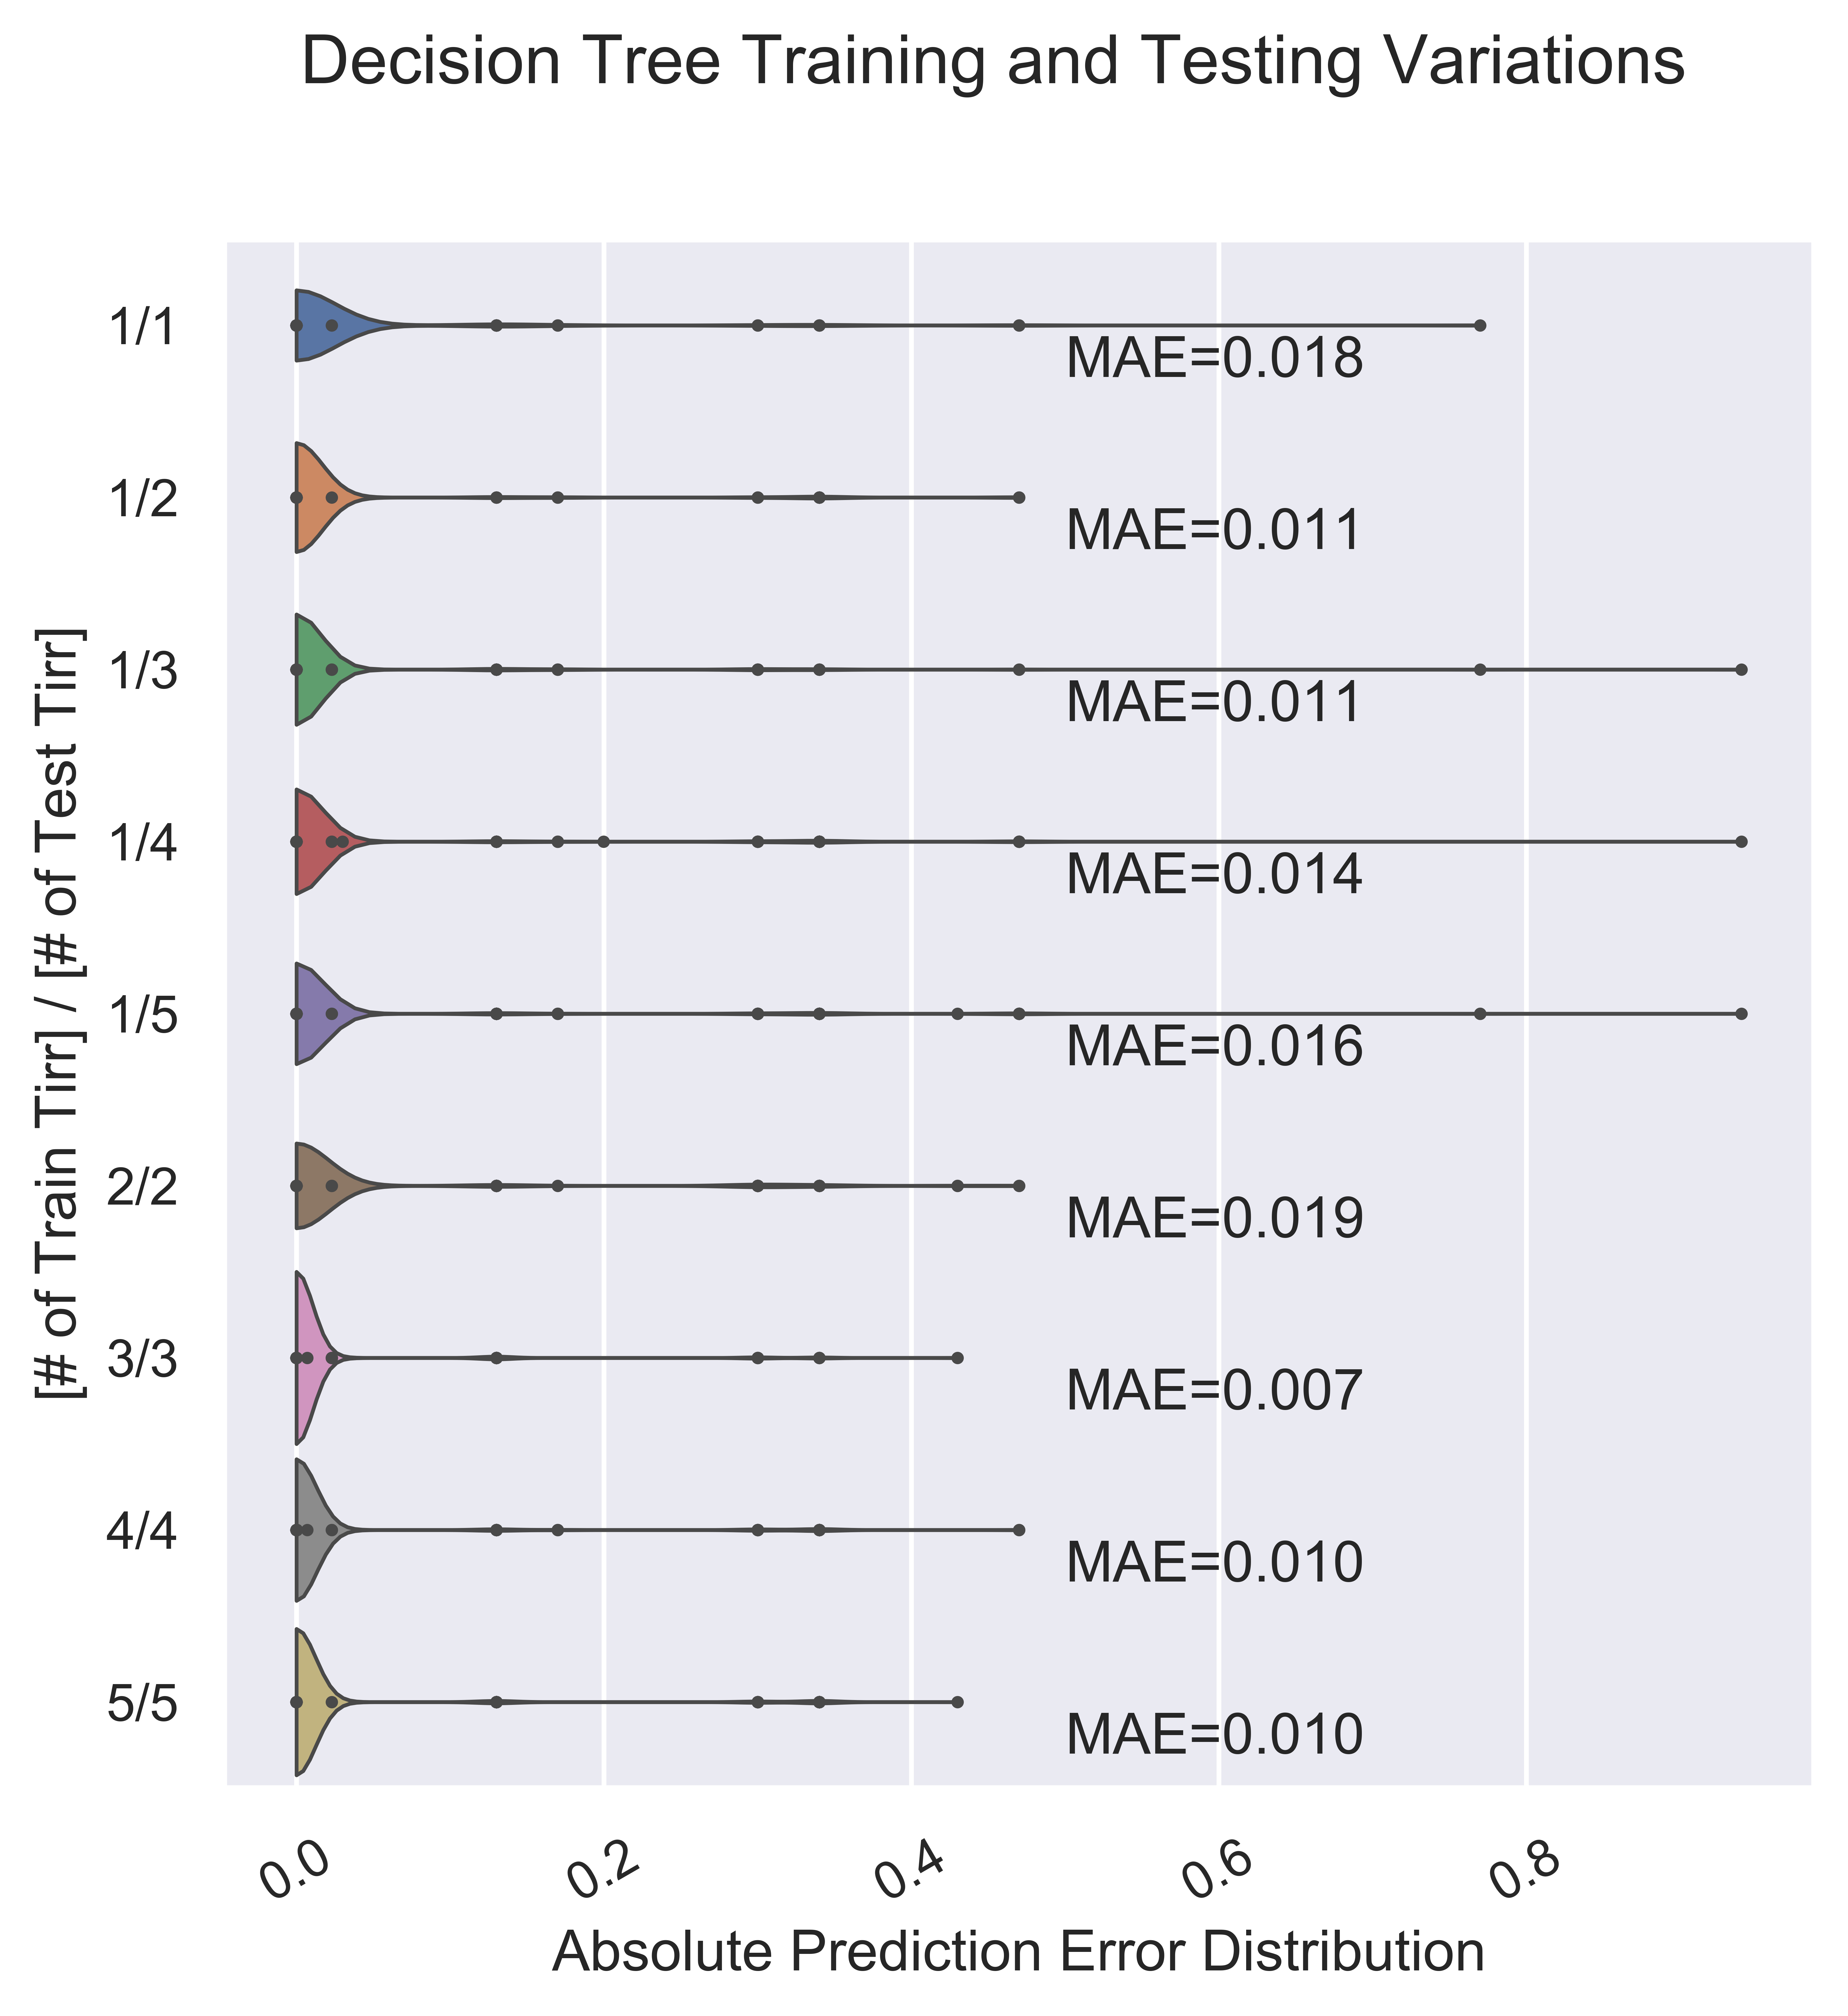

In [140]:
fig = plt.figure(figsize=(6, 6), dpi=1200)
fig.suptitle("Decision Tree Training and Testing Variations")
ax = fig.add_subplot(111)
# sns.boxplot(data=abs_results, linewidth=1, color='orange', orient='h')
sns.violinplot(data=abs_results, cut=0, width=1, linewidth=.8,
              inner='point', orient='h', scale='area')
ax.set_yticklabels(names)
ax.set_ylabel("[# of Train Tirr] / [# of Test Tirr]")
plt.xscale('linear')
plt.xlabel("MAE")
plt.xlabel("Absolute Prediction Error Distribution")
plt.xticks(rotation=30)
# plt.xlim(0.01, 0.02)
plt.yticks(rotation=0)
plt.text(0.5, 0.3, "MAE=0.018")
plt.text(0.5, 1.3, "MAE=0.011")
plt.text(0.5, 2.3, "MAE=0.011")
plt.text(0.5, 3.3, "MAE=0.014")
plt.text(0.5, 4.3, "MAE=0.016")
plt.text(0.5, 5.3, "MAE=0.019")
plt.text(0.5, 6.3, "MAE=0.007")
plt.text(0.5, 7.3, "MAE=0.010")
plt.text(0.5, 8.3, "MAE=0.010")
plt.show()
